In [1]:
!nvidia-smi

Wed May 26 04:45:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Tips & suggestions
* You can choose a wide set of models from the **get_model** interface : ["resnest*", "resnet*", "resnext*", "efficientnet*" ...]
* You can change the learning rate scheduler: OneCycle ? ReduceOnPlateau ?
* Adds secondary labels
* Use train & test metadata (dates, positions (longitude, latitude), ...)
* Add melspecs augmentation

**For Colab training, you just have to uncomment the first cells**

# Versions

* **v1** : initial version
* **v3** : enable training on whole (no truncation) record melspecs

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
# ! mkdir ~/.kaggle
# ! cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# %%time

# import os
# if not os.path.exists("/content/datasets/audio_images"):
#   !mkdir datasets
#   !kaggle datasets download -d kneroma/kkiller-birdclef-2021
#   !unzip /content//kkiller-birdclef-2021.zip -d datasets

In [5]:
!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest

In [6]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from resnest.torch import resnest50

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [7]:
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
import resnest.torch as resnest_torch

In [8]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [9]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

FOLD = 4
EPOCHS = 30
DEBUG = False
if DEBUG:
    EPOCHS = 2
TRAINING_MODEL = "efficientnet-b0"

MAX_READ_SAMPLES = 5 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

# # For colab
# DATA_ROOT = Path("/content/datasets/")
# TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
# TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")
# MODEL_ROOT = Path("/content/drive/My Drive/Kaggle/BirdClef2021/models")

DATA_ROOT = Path("../input/birdclef-2021")
# TRAIN_IMAGES_ROOT = Path("../input/kkiller-birdclef-2021/audio_images")
# TRAIN_LABELS_FILE = Path("../input/kkiller-birdclef-2021/rich_train_metadata.csv")

MEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
TRAIN_LABEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

MODEL_ROOT = Path(".")

In [10]:
TRAIN_BATCH_SIZE = 100
TRAIN_NUM_WORKERS = 2

VAL_BATCH_SIZE = 128
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


# AUGS

In [11]:
def random_power(images, power = 1.5, c= 0.7):
    images = images - images.min()
    images = images/(images.max()+0.0000001)
    images = images**(random.random()*power + c)
    return images

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)
    
    return V

In [12]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
    df = None
    LABEL_IDS = {}
    
    for file_path in mel_paths:
        temp = pd.read_csv(str(file_path), index_col=0)
        temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
        df = temp if df is None else df.append(temp)
    secondary_labels = pd.read_csv('../input/my-birdcall-datasets/train1.csv')
    secondary_labels['filename'] = secondary_labels['filename'].apply(lambda x: x.replace('mp3','ogg'))
    df = df.merge(secondary_labels[["filename",'labels_bg']], how = 'left', left_on='filename', right_on='filename',copy=False)  
    df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

    for file_path in train_label_paths:
        with open(str(file_path)) as f:
            LABEL_IDS.update(json.load(f))

    return LABEL_IDS, df

In [13]:
# df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
# df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
# LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

# print(df.shape)
# df.head()

In [14]:
labels = pd.read_csv('../input/birdclef-2021/train_metadata.csv')
labels.sample(15)
labels[labels.primary_label == 'camwar']

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url


In [15]:
LABEL_IDS, df = get_df()

#print(LABEL_IDS)
#if 'camwar' not in LABEL_IDS.keys():
#    print("lol")
print(df.shape)
df.head()

(62874, 22)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,...,time,url,label_id,filepath,frames,sr,duration,fold,impath,labels_bg
0,acafly,[amegfi],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,...,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0,../input/kkiller-birdclef-mels-computer-d7-par...,NaN
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,...,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1,../input/kkiller-birdclef-mels-computer-d7-par...,NaN
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,...,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3,../input/kkiller-birdclef-mels-computer-d7-par...,NaN
3,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,...,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4,../input/kkiller-birdclef-mels-computer-d7-par...,NaN
4,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,...,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2,../input/kkiller-birdclef-mels-computer-d7-par...,NaN


In [16]:
df["primary_label"].value_counts()

comrav     500
eursta     500
gbwwre1    500
barswa     500
houwre     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
stvhum2      8
crfpar       8
Name: primary_label, Length: 397, dtype: int64

In [17]:
df["label_id"].min(), df["label_id"].max()

(0, 396)

In [18]:
df['labels_bg'].value_counts()


rewbla                                                    257
houspa                                                    195
amerob                                                    192
norcar                                                    165
houfin                                                    142
                                                         ... 
cangoo chispa wilsni1 rewbla amerob dusfly sora ruckin      1
horlar wesmea                                               1
blugrb1 eastow carwre indbun                                1
blujay whtspa comyel ovenbi1                                1
purfin olsfly foxspa                                        1
Name: labels_bg, Length: 5903, dtype: int64

In [19]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=True)
    elif "wsl" in name:
        model = torch.hub.load("facebookresearch/WSL-Images", name)
    elif name.startswith("resnext") or  name.startswith("resnet"):
        model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    elif name.startswith("tf_efficientnet_b"):
        model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        model = EfficientNet.from_pretrained(name)
    else:
        model = pretrainedmodels.__dict__[name](pretrained='imagenet')

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [20]:
def load_data(df):
    def load_row(row):
        # impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [21]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

  0%|          | 0/62874 [00:00<?, ?it/s]

62874

shape: (5, 128, 281)


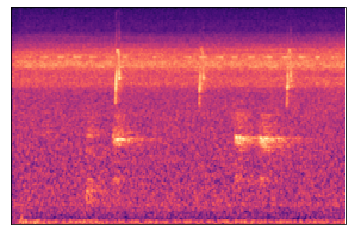

In [22]:
print("shape:", next(iter(audio_image_store.values())).shape)
lbd.specshow(next(iter(audio_image_store.values()))[0])

In [23]:
pd.Series([len(x) for x in audio_image_store.values()]).value_counts()

5    39090
1     7271
2     5886
3     5625
4     5002
dtype: int64

In [24]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        y = np.zeros(self.num_classes, dtype=np.float32) + 0.0025
        
        birds, background = [],[]
        #print(row)
        
        bird_list = row.secondary_labels
        bird_list.append(row.primary_label)
        
        #print("Bird LIST",bird_list)
        # Birds in the file | Птицы в файле
        labels_bird = bird_list
        #print("Птиц в файле",labels_bird)
        for bird in labels_bird:
            if not bird in birds and bird != self.num_classes:
                if bird in LABEL_IDS.keys():
                    birds.append(LABEL_IDS[bird])
        
        # Birds in the background | Птицы на фоне 
        #print(type(row.labels_bg))
        if type(row.labels_bg) == str:
            #print("Птицы на фоне",row.labels_bg)
            labels_bg = row.labels_bg.split()
            for bg in labels_bg:
                if not bg in background:
                    #print(bg)
                    if bg in LABEL_IDS.keys():
                        background.append(LABEL_IDS[bg])
                    
        image = self.audio_image_store[row.filename]
    
        image = image[np.random.choice(len(image))]
        
        # AUGMETATION REGION
        image = random_power(image, power = 2, c= 0.7)
        image = mono_to_color(image)
        
        image = self.normalize(image)
        
        # If there are no birds, then the background | Усли нет птиц, значит фон
        if not birds:
            birds.append(self.num_classes)        
        
        # The background is 0.3, and the marked bird is 1 | Фон это 0.3, а помеченая птица 1
        for bird in background:
            if bird < len(y):
                y[bird]=0.3
        
        for bird in birds:
            #if not bird==264:
            y[bird]= 0.995
        
        #t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        #t[row.label_id] = 0.995
        
        return image, y

In [25]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(df)

62874

In [26]:
x, y = ds[np.random.choice(len(ds))]
# x, y = ds[0]
x.shape, y.shape, np.where(y >= 0.5)

((3, 128, 281), (397,), (array([131, 282, 368]),))

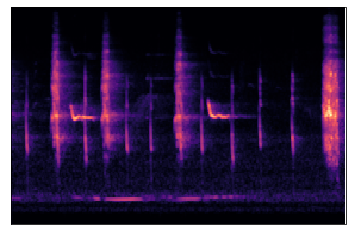

In [27]:
lbd.specshow(x[0])

In [28]:
y[:5]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025], dtype=float32)

# Training the model

In [29]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)

    optimizer.zero_grad()
    o = net(xb)
    loss = criterion(o, yb)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        l = loss.item()

        o = o.sigmoid()
        yb = (yb > 0.5 )*1.0
        lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

        o = (o > 0.5)*1.0

        prec = (o*yb).sum()/(1e-6 + o.sum())
        rec = (o*yb).sum()/(1e-6 + yb.sum())
        f1 = 2*prec*rec/(1e-6+prec+rec)

    if  scheduler is not None:
        scheduler.step()

    return l, lrap, f1.item(), rec.item(), prec.item()

In [30]:
@torch.no_grad()
def evaluate(net, criterion, val_loader):
    net.eval()

    os, y = [], []
    val_loader = tqdm(val_loader, leave = False, total=len(val_loader))

    for icount, (xb, yb) in  enumerate(val_loader):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [31]:
def one_epoch(net, criterion, optimizer, scheduler, train_loader, val_loader):
    net.train()
    l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
    train_loader = tqdm(train_loader, leave = False)
    epoch_bar = train_loader

    for (xb, yb) in  epoch_bar:
        # epoch_bar.set_description("----|----|----|----|---->")
        _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
        l += _l
        lrap += _lrap
        f1 += _f1
        rec += _rec
        prec += _prec

        icount += 1

        if hasattr(epoch_bar, "set_postfix") and not icount%10:
            epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
            )
  
    scheduler.step()

    l /= icount
    lrap /= icount
    f1 /= icount
    rec /= icount
    prec /= icount

    l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_loader)

    return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [32]:
class AutoSave:
    def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
        self.top_k = top_k
        self.logs = []
        self.metric = metric
        self.mode = mode
        self.root = Path(root or MODEL_ROOT)
        assert self.root.exists()
        self.name = name

        self.top_models = []
        self.top_metrics = []

    def log(self, model, metrics):
        metric = metrics[self.metric]
        rank = self.rank(metric)

        self.top_metrics.insert(rank+1, metric)
        if len(self.top_metrics) > self.top_k:
            self.top_metrics.pop(0)

        self.logs.append(metrics)
        self.save(model, metric, rank, metrics["epoch"])


    def save(self, model, metric, rank, epoch):
        t = time.strftime("%Y%m%d%H%M%S")
        name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
        name = re.sub(r"[^\w_-]", "", name) + ".pth"
        path = self.root.joinpath(name)

        old_model = None
        self.top_models.insert(rank+1, name)
        if len(self.top_models) > self.top_k:
            old_model = self.root.joinpath(self.top_models[0])
            self.top_models.pop(0)      

        torch.save(model.state_dict(), path.as_posix())

        if old_model is not None:
            old_model.unlink()

        self.to_json()


    def rank(self, val):
        r = -1
        for top_val in self.top_metrics:
            if val <= top_val:
                return r
            r += 1

        return r
  
    def to_json(self):
        # t = time.strftime("%Y%m%d%H%M%S")
        name = "{}_logs".format(self.name)
        name = re.sub(r"[^\w_-]", "", name) + ".json"
        path = self.root.joinpath(name)

        with path.open("w") as f:
            json.dump(self.logs, f, indent=2)


In [33]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

    save_root = Path(save_root) or MODEL_ROOT

    saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

    net = get_model(model_name).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(net.parameters(), lr=8e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

    train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
    train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

    val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
    val_loader = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

    epochs_bar = tqdm(list(range(epochs)), leave=False)
    for epoch  in epochs_bar:
        epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
        net.train()

        (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
            net=net,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loader=train_loader,
            val_loader=val_loader,
          )

        epochs_bar.set_postfix(
        loss="({:.6f}, {:.6f})".format(l, l_val),
        prec="({:.3f}, {:.3f})".format(prec, prec_val),
        rec="({:.3f}, {:.3f})".format(rec, rec_val),
        f1="({:.3f}, {:.3f})".format(f1, f1_val),
        lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )

        print(
            "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
                epoch=epoch,
                loss="({:.6f}, {:.6f})".format(l, l_val),
                prec="({:.3f}, {:.3f})".format(prec, prec_val),
                rec="({:.3f}, {:.3f})".format(rec, rec_val),
                f1="({:.3f}, {:.3f})".format(f1, f1_val),
                lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
            )
        )

        if save:
            metrics = {
              "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
              "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
              "epoch": epoch,
            }

        saver.log(net, metrics)

In [34]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
    gc.collect()
    torch.cuda.empty_cache()

    save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
    save_root.mkdir(exist_ok=True, parents=True)

    fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)

    for fold, val_set in fold_bar:
        if folds and not fold in folds:
            continue
      
        print(f"\n############################### [FOLD {fold}]")
        fold_bar.set_description(f"[FOLD {fold}]")
        train_set = np.setdiff1d(df.index, val_set)

        one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)

        gc.collect()
        torch.cuda.empty_cache()

In [35]:
print("\n\n###########################################", TRAINING_MODEL.upper())
train(TRAINING_MODEL, epochs=EPOCHS, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[FOLD])



########################################### EFFICIENTNET-B0


  0%|          | 0/5 [00:00<?, ?it/s]


############################### [FOLD 4]


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[00] loss: (0.047901, 0.037990) lrap: (0.110, 0.195) f1: (0.005, 0.013) rec: (0.005, 0.007) prec: (0.174, 0.588)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[01] loss: (0.036123, 0.035799) lrap: (0.315, 0.390) f1: (0.076, 0.127) rec: (0.041, 0.069) prec: (0.733, 0.816)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[02] loss: (0.034049, 0.033571) lrap: (0.448, 0.479) f1: (0.190, 0.258) rec: (0.109, 0.155) prec: (0.802, 0.760)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[03] loss: (0.032677, 0.032721) lrap: (0.526, 0.537) f1: (0.276, 0.314) rec: (0.167, 0.195) prec: (0.822, 0.801)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[04] loss: (0.031681, 0.031980) lrap: (0.577, 0.568) f1: (0.343, 0.341) rec: (0.217, 0.214) prec: (0.834, 0.835)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[05] loss: (0.030862, 0.031345) lrap: (0.616, 0.596) f1: (0.394, 0.368) rec: (0.258, 0.235) prec: (0.845, 0.846)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[06] loss: (0.030194, 0.030911) lrap: (0.646, 0.618) f1: (0.436, 0.404) rec: (0.294, 0.265) prec: (0.853, 0.845)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[07] loss: (0.029614, 0.030977) lrap: (0.673, 0.623) f1: (0.469, 0.412) rec: (0.323, 0.272) prec: (0.860, 0.846)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[08] loss: (0.029052, 0.030603) lrap: (0.698, 0.631) f1: (0.499, 0.440) rec: (0.353, 0.298) prec: (0.864, 0.842)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[09] loss: (0.028593, 0.030359) lrap: (0.717, 0.655) f1: (0.524, 0.476) rec: (0.376, 0.332) prec: (0.871, 0.839)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[10] loss: (0.028111, 0.030195) lrap: (0.737, 0.661) f1: (0.550, 0.494) rec: (0.402, 0.351) prec: (0.878, 0.835)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[11] loss: (0.027658, 0.029983) lrap: (0.755, 0.663) f1: (0.573, 0.504) rec: (0.426, 0.365) prec: (0.883, 0.812)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[12] loss: (0.027275, 0.029598) lrap: (0.770, 0.678) f1: (0.593, 0.526) rec: (0.447, 0.390) prec: (0.889, 0.810)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[13] loss: (0.026870, 0.029500) lrap: (0.785, 0.683) f1: (0.612, 0.538) rec: (0.466, 0.406) prec: (0.896, 0.797)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[14] loss: (0.026487, 0.029445) lrap: (0.800, 0.687) f1: (0.630, 0.540) rec: (0.487, 0.406) prec: (0.897, 0.805)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[15] loss: (0.026116, 0.029507) lrap: (0.813, 0.689) f1: (0.648, 0.540) rec: (0.507, 0.403) prec: (0.904, 0.819)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[16] loss: (0.025813, 0.029426) lrap: (0.824, 0.690) f1: (0.663, 0.548) rec: (0.524, 0.418) prec: (0.908, 0.796)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[17] loss: (0.025460, 0.029387) lrap: (0.838, 0.697) f1: (0.681, 0.553) rec: (0.544, 0.418) prec: (0.913, 0.817)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[18] loss: (0.025160, 0.029261) lrap: (0.847, 0.700) f1: (0.694, 0.561) rec: (0.559, 0.437) prec: (0.919, 0.786)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[19] loss: (0.024904, 0.029262) lrap: (0.856, 0.699) f1: (0.706, 0.560) rec: (0.574, 0.429) prec: (0.921, 0.805)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[20] loss: (0.024640, 0.029368) lrap: (0.865, 0.701) f1: (0.719, 0.560) rec: (0.589, 0.429) prec: (0.927, 0.808)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[21] loss: (0.024410, 0.029323) lrap: (0.873, 0.702) f1: (0.731, 0.566) rec: (0.603, 0.437) prec: (0.931, 0.804)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[22] loss: (0.024220, 0.029227) lrap: (0.878, 0.705) f1: (0.739, 0.569) rec: (0.613, 0.441) prec: (0.933, 0.800)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[23] loss: (0.024027, 0.029250) lrap: (0.885, 0.706) f1: (0.750, 0.571) rec: (0.626, 0.444) prec: (0.938, 0.800)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[24] loss: (0.023887, 0.029214) lrap: (0.890, 0.706) f1: (0.755, 0.570) rec: (0.633, 0.442) prec: (0.938, 0.802)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[25] loss: (0.023746, 0.029209) lrap: (0.894, 0.707) f1: (0.762, 0.572) rec: (0.641, 0.444) prec: (0.943, 0.801)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[26] loss: (0.023649, 0.029246) lrap: (0.897, 0.707) f1: (0.768, 0.570) rec: (0.649, 0.441) prec: (0.943, 0.806)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[27] loss: (0.023596, 0.029232) lrap: (0.898, 0.709) f1: (0.770, 0.572) rec: (0.651, 0.444) prec: (0.945, 0.804)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[28] loss: (0.023521, 0.029247) lrap: (0.900, 0.709) f1: (0.773, 0.572) rec: (0.654, 0.444) prec: (0.946, 0.804)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[29] loss: (0.023514, 0.029240) lrap: (0.900, 0.709) f1: (0.775, 0.572) rec: (0.658, 0.444) prec: (0.945, 0.802)
